In [2]:
!git clone https://github.com/zxzhaixiang/QMDB

Cloning into 'QMDB'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 545 (delta 107), reused 138 (delta 71), pack-reused 354
Receiving objects: 100% (545/545), 265.55 MiB | 36.83 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Checking out files: 100% (91/91), done.


In [1]:
#datapath = './QMDB/data/processed_data/'
datapath = './../data/processed_data/'


In [4]:
!pip install hiddenlayer

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [248]:
savepath = './gdrive/My Drive/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cpu


## Loading data and prepare data loader

In [5]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [6]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [7]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [8]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [9]:
genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
genres_list = list(genres_list)
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['comedy', 'animation', 'fantasy', 'foreign', 'family', 'crime', 'science', 'adventure', 'history', 'action', 'tv', 'drama', 'thriller', 'horror', 'movie', 'documentary', 'fiction', 'western', 'romance', 'mystery', 'war', 'music']


In [10]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

In [11]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding = pickle.load(f)

In [12]:
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding:
    kw_embedding[key] = torch.FloatTensor(kw_embedding[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [13]:
kw_set = set(kw_embedding.keys())

In [14]:
kw_by_movie = [[kw for kw in kws.split(' ')] for kws in movie_df['kws_all']]

In [15]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [167]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)/5
G    = torch.tensor(genres, dtype=torch.float)

In [168]:
batch_size = 4096
validation_split = .1
shuffle_dataset = True
random_seed = 42

In [169]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [170]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*2).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

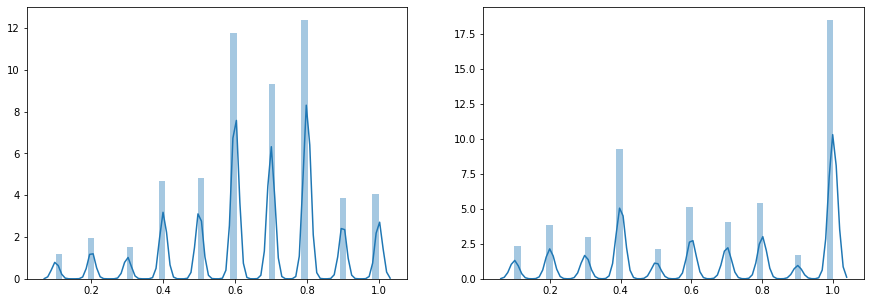

In [171]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [172]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [173]:
#ind = train_idx
ind = train_idx_resampled

train_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [174]:
ind = val_idx
val_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [231]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [285]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

        self.genres_layers = nn.Sequential(
                                nn.Linear(self.genres_dim, self.g_latent_dim)
        )
        
        self.fc_layers_relevance = nn.Sequential(
            nn.Linear(self.g_latent_dim + self.i_latent_dim + 64, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, genres, em_query):
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        genres_em = self.genres_layers(genres)
        
        final_query_em = user_em + genres_em + em_query
        
        relevance_em = torch.cat((movie_em, genres_em, em_query), dim=2)
        relevance_em = relevance_em.view(-1,self.g_latent_dim + self.i_latent_dim + 64)

        relevance_score = self.fc_layers_relevance(relevance_em)

        return relevance_score, torch.bmm(final_query_em, movie_em.view(-1,self.i_latent_dim, 1))

In [286]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 64, 'item_latent_dim': 64,
          'genre_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 64, 'item_latent_dim': 64, 'genre_latent_dim': 64}


In [287]:
CF = NCF(config).to(device)

In [288]:
CF_criterion = nn.MSELoss()
CF_relevance_criterion = nn.BCELoss()

CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [289]:
count_parameters(CF)

542753

In [290]:
# hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
#    torch.LongTensor(np.zeros((2,1))).to(device), #mids
#    torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
#    torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
#    )) #hr


In [291]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   ) #hr


(tensor([[0.5693],
         [0.5693]], grad_fn=<SigmoidBackward>), tensor([[[-0.0850]],
 
         [[-0.0850]]], grad_fn=<BmmBackward>))

## Training

In [292]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss_score=0, loss_relevance=0), display_id = True)

    def update(self, i, loss_score=0, loss_relevance=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss_score=loss_score, loss_relevance=loss_relevance))
    
    def progress(self, value, loss_score=0, loss_relevance=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss [rating={loss_score:0.5f}, relevance={loss_relevance:0.5f}] <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value, M=M, loss_score=loss_score, loss_relevance=loss_relevance))

In [293]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

1681 mini-batches in training dataset, 83 mini-batches in validation dataset


In [294]:
epoch_num = 50

In [295]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.002
    elif(epoch<10):
        lr = 0.001
    elif (epoch<20):
        lr = 0.0005
    else:
        lr = 0.00025

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [296]:
G = G.to(device)

In [297]:
def get_irrelevant_movies(movies):
#     res = torch.clone(movies)
#     for i, m in enumerate(movies):
#         j0 = m.item()
#         j = j0
#         while(j==j0):
#             j = random.sample(range(nM),1)[0]
#             print(j)
#         res[i,0] = j
    res = np.random.choice(nM, movies.shape[0], replace=True)
    return torch.LongTensor(res).view(movies.shape)

In [298]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        if len(kw_list)==0:
            return kw_default_embedding
        else:
            res = torch.zeros(kw_default_embedding.shape)
            for kw in kw_list:
#                if kw in kw_set:
                res+=kw_embedding[kw]
            return res/len(kw_list)

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        kws = random.sample(kw_by_movie[i], random.randrange(len(kw_by_movie[i])))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [284]:
train_losses = []
train_score_losses = []
train_relevance_losses = []

val_losses = []
train_losses_epoch = []
val_losses_epoch = []


for epoch in range(epoch_num):
    
    #torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel'))

    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    train_loss = 0
    train_loss_score = 0
    train_loss_relevance = 0
    
    val_loss = 0
    tmp_loss_score = 0
    tmp_loss_relevance = 0
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    CF.train()
    
    for i,(users, movies, ratings) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss_score, tmp_loss_relevance)

        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movie = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[movies], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(rel_score, torch.ones(rel_score.shape)) + \
                         CF_relevance_criterion(irrel_score, torch.zeros(rel_score.shape)) 
        
        loss = loss_rating + loss_relevance
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        tmp_loss_score = loss_rating.item()
        tmp_loss_relevance = loss_relevance.item()
        
        train_loss += loss.item()
        train_loss_score += loss_rating.item()
        train_loss_relevance += loss_relevance.item()
        
        train_losses.append(loss.item())
        train_score_losses.append(tmp_loss_score)
        train_relevance_losses.append(tmp_loss_relevance)
        
    train_loss/=nBatch_train
    train_losses_epoch.append(train_loss)
    
    CF.eval()
    for i, (u,m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        Q = get_query_tensor(m)
        Q_irrelevant = get_query_tensor(m, random_selection = True)

        rhat = CF(U, I, G[m], Q)
        loss = CF_criterion(rhat, R)

        val_loss += loss.item()
        val_losses.append(loss.item())
        
    val_loss/=nBatch_val
    val_losses_epoch.append(val_loss)
    
    print('epoch[{}/{}], train loss = {}, val loss = {}'.
         format(epoch, epoch_num, train_loss, val_loss))
    
    if (epoch%5==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

Training epoch 0/50


torch.Size([4096, 1, 64])
torch.Size([4096, 1, 64])
torch.Size([4096, 1, 64])
torch.Size([4096, 1, 64])


RuntimeError: leaf variable has been moved into the graph interior

In [1]:
torch.save(CF.state_dict(), './cfmodel')
torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel'))


NameError: ignored

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()
User_Em = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
ave_User_Em = User_Em.mean(axis=0, keepdims=True)

In [0]:
with open('./movie_embedding', 'wb') as f:
    pickle.dump(Movie_Em, f)
with open('./ave_user_embedding', 'wb') as f:
    pickle.dump(ave_User_Em, f)


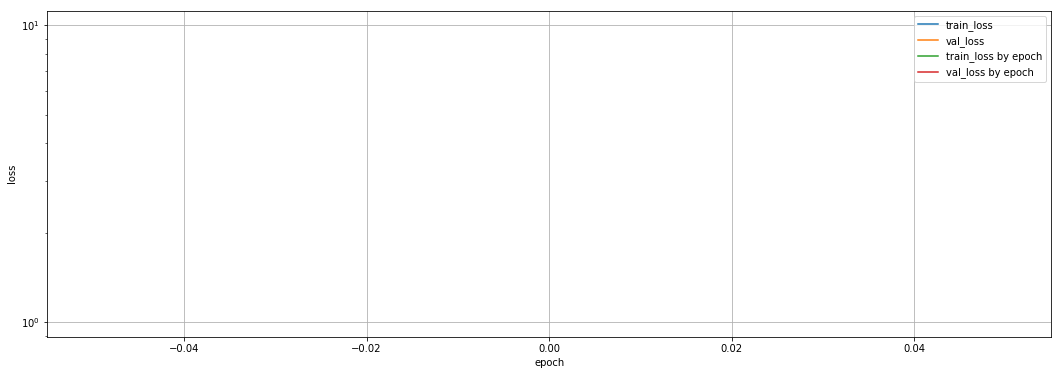

In [48]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch_num-1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch_num-1, len(val_losses)),val_losses,label='val_loss')
plt.plot(train_losses_epoch,label='train_loss by epoch')
plt.plot(val_losses_epoch,label='val_loss by epoch')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [49]:
r_real = []
r_pred = []
        
with torch.no_grad():
    for i, (u, m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        Q = get_query_tensor(m)
        rhat = CF(U,I, G[m], Q)
        r_real+=list(r.detach().cpu().numpy().reshape(-1))
        r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))    
        if(i%20==0):
            print('{}/{}'.format(i,nBatch_val))

0/83
20/83
40/83
60/83
80/83


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [52]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -1.0336109399795532, std = 0.9301411509513855
mae = 1.1479812860488892
rmse = 1.3905084133148193
slope=0.5316347376233511, r2=0.5732452294996436
pearson = 0.5732452294996428, spearman = 0.5530056564078774


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

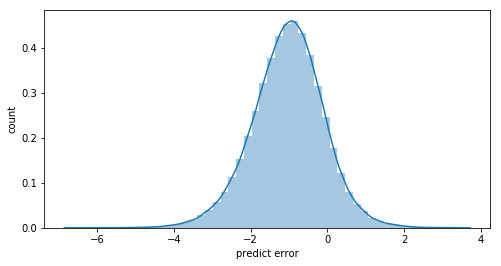

In [53]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [55]:
pd_df.head(50)

,real,pred,userId,movieId,index,Unnamed: 0,title,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,3.5,3.357842,2078,3521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664,3.774096,0.671679
1,3.0,3.706930,968,285,90.0,90.0,Tank Girl,90.0,9067.0,1995.0,"comedy,fiction,science,action,fantasy",post tanks pop woman a malcolm reincarnation n...,1161.0,2.521533,1.125321,524,2.865458,0.838560
2,4.0,0.893817,3176,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,682,2.368035,1.128084
3,3.0,2.562538,3779,1892,668.0,668.0,Rushmore,668.0,11545.0,1998.0,"comedy,drama",wolf and theater than literate more once roman...,2391.0,3.708072,0.994700,731,3.368673,0.786350
4,3.0,2.240297,4209,2797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,964,3.082988,0.775308
5,3.0,2.954269,3952,1667,588.0,588.0,"Addams Family, The",588.0,2907.0,1991.0,"comedy,fantasy,horror",anjelica lloyd gothic a barry bermuda sonnenfe...,2384.0,3.192114,0.872365,914,3.434902,0.703906
6,4.5,3.497823,1027,1901,673.0,673.0,Rambo III,673.0,1370.0,1988.0,"action,war,adventure,thriller",union peter golden liberation smith submachine...,1237.0,2.305578,0.993096,673,4.236256,0.834019
7,4.0,0.547937,1781,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415,3.048193,1.174956
8,4.0,2.175295,3462,2147,755.0,755.0,Arachnophobia,755.0,6488.0,1990.0,"comedy,horror",always frank marshall animal invasive jeff jan...,2187.0,2.861454,0.934869,977,3.755374,0.639010
9,3.5,2.889683,634,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411,3.290754,0.666269


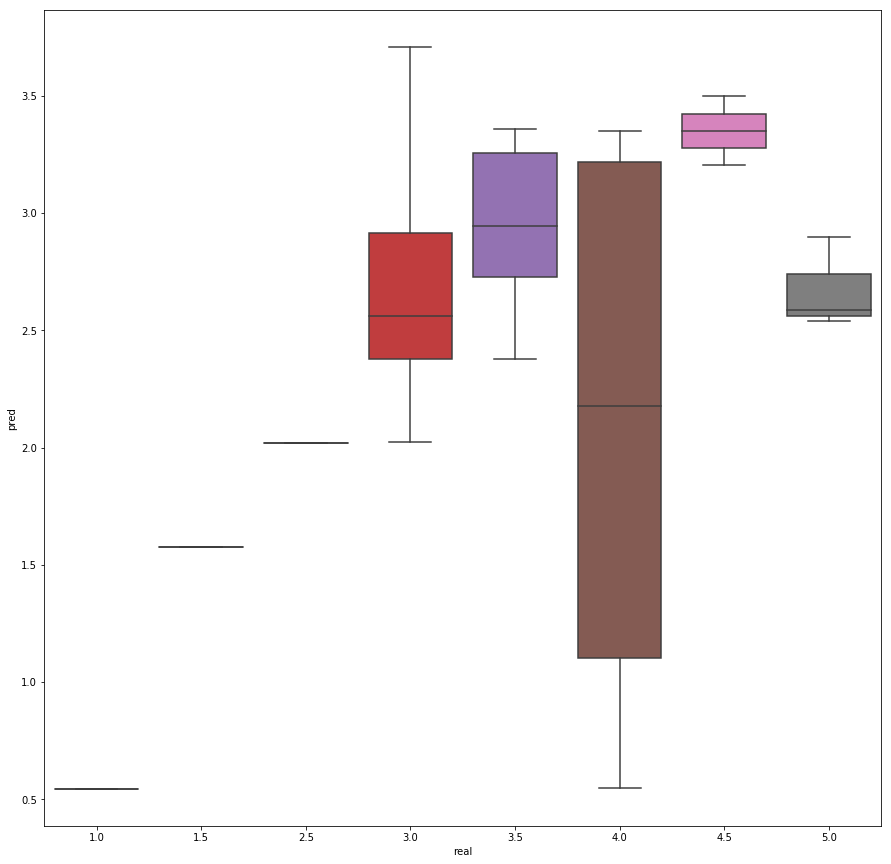

In [56]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

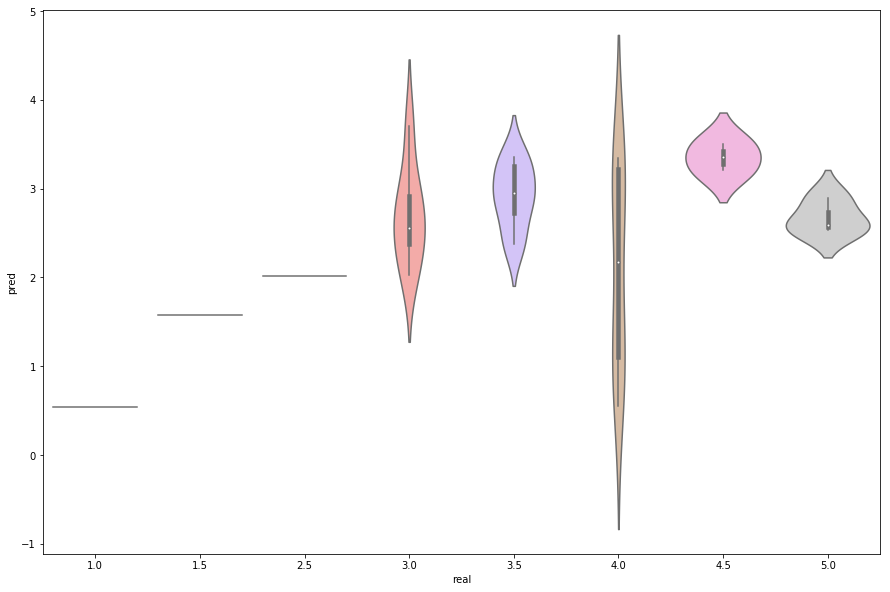

In [57]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


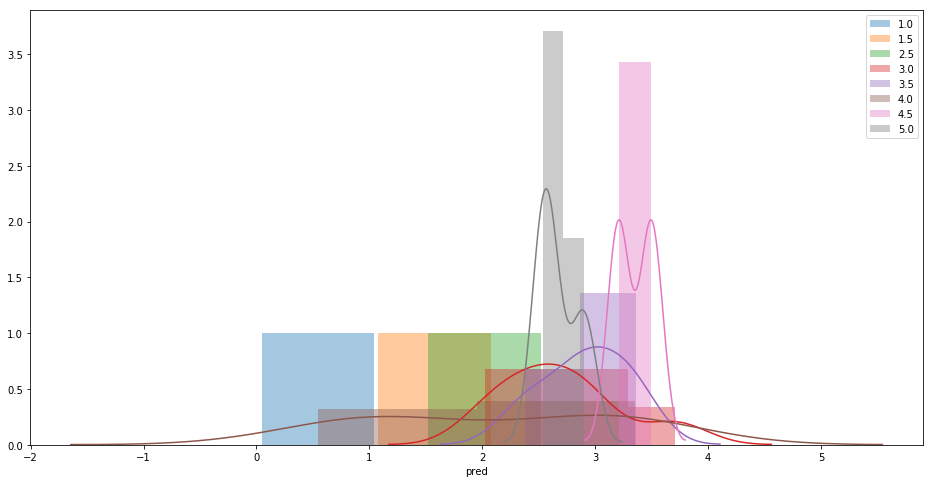

In [85]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
genre_weight = CF.genres_layers[0].weight.detach().cpu().numpy().T

pca = decomposition.PCA(n_components = 5)
G_std = StandardScaler().fit_transform(genre_weight)
G_pca = pca.fit_transform(G_std)

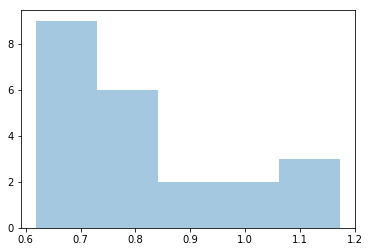

In [60]:
L = np.linalg.norm(genre_weight,axis=1,keepdims=True)
sns.distplot(L,kde=False)

(-3.3923457, 9.661248)

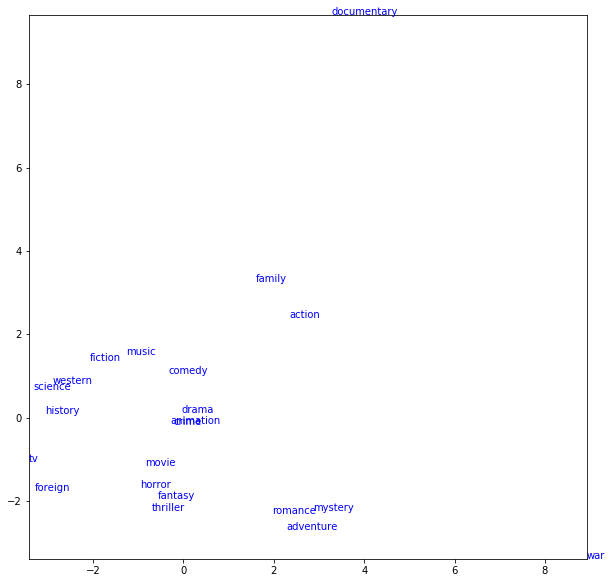

In [61]:
plt.figure(figsize=(10,10))

xs = []
ys = []

for key in genres_dict:
    i = genres_dict[key]
    x,y = G_pca[i,0], G_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,key,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

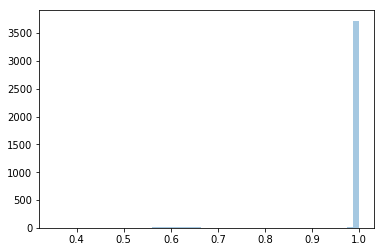

In [64]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-6.538692104509311, 7.194252217031621, -5.613498183732297, 7.294629072735806)

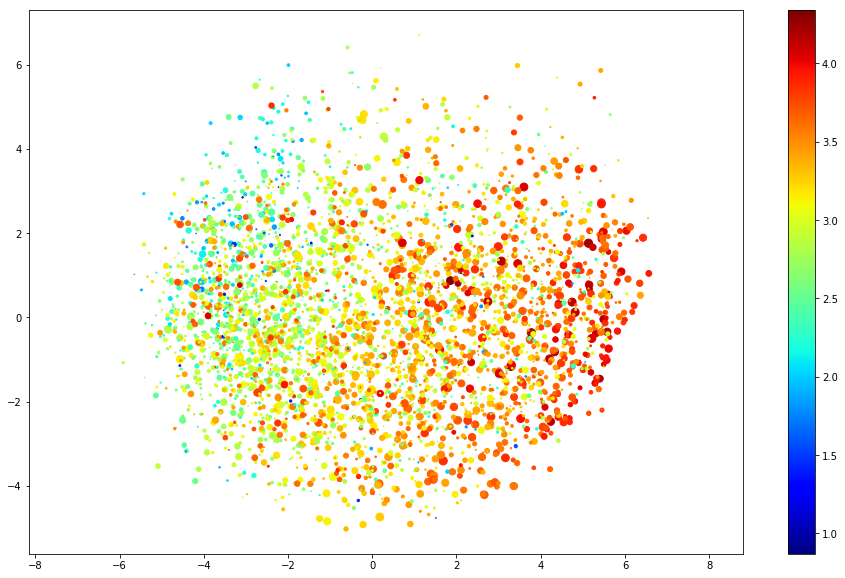

In [66]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

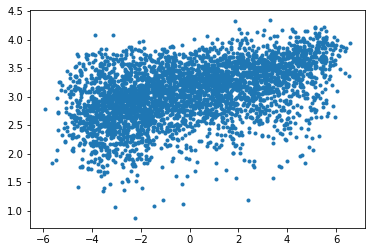

In [67]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

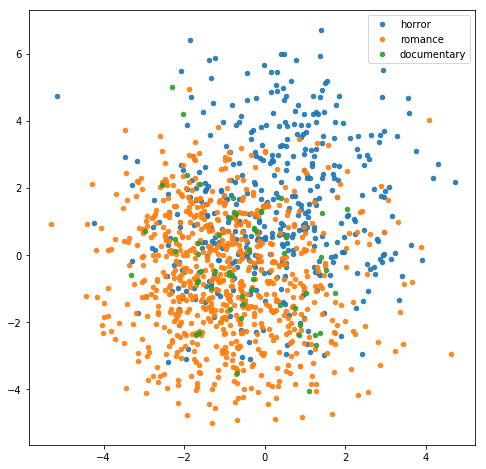

In [68]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','documentary']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

(-4.842083, 4.8258953)

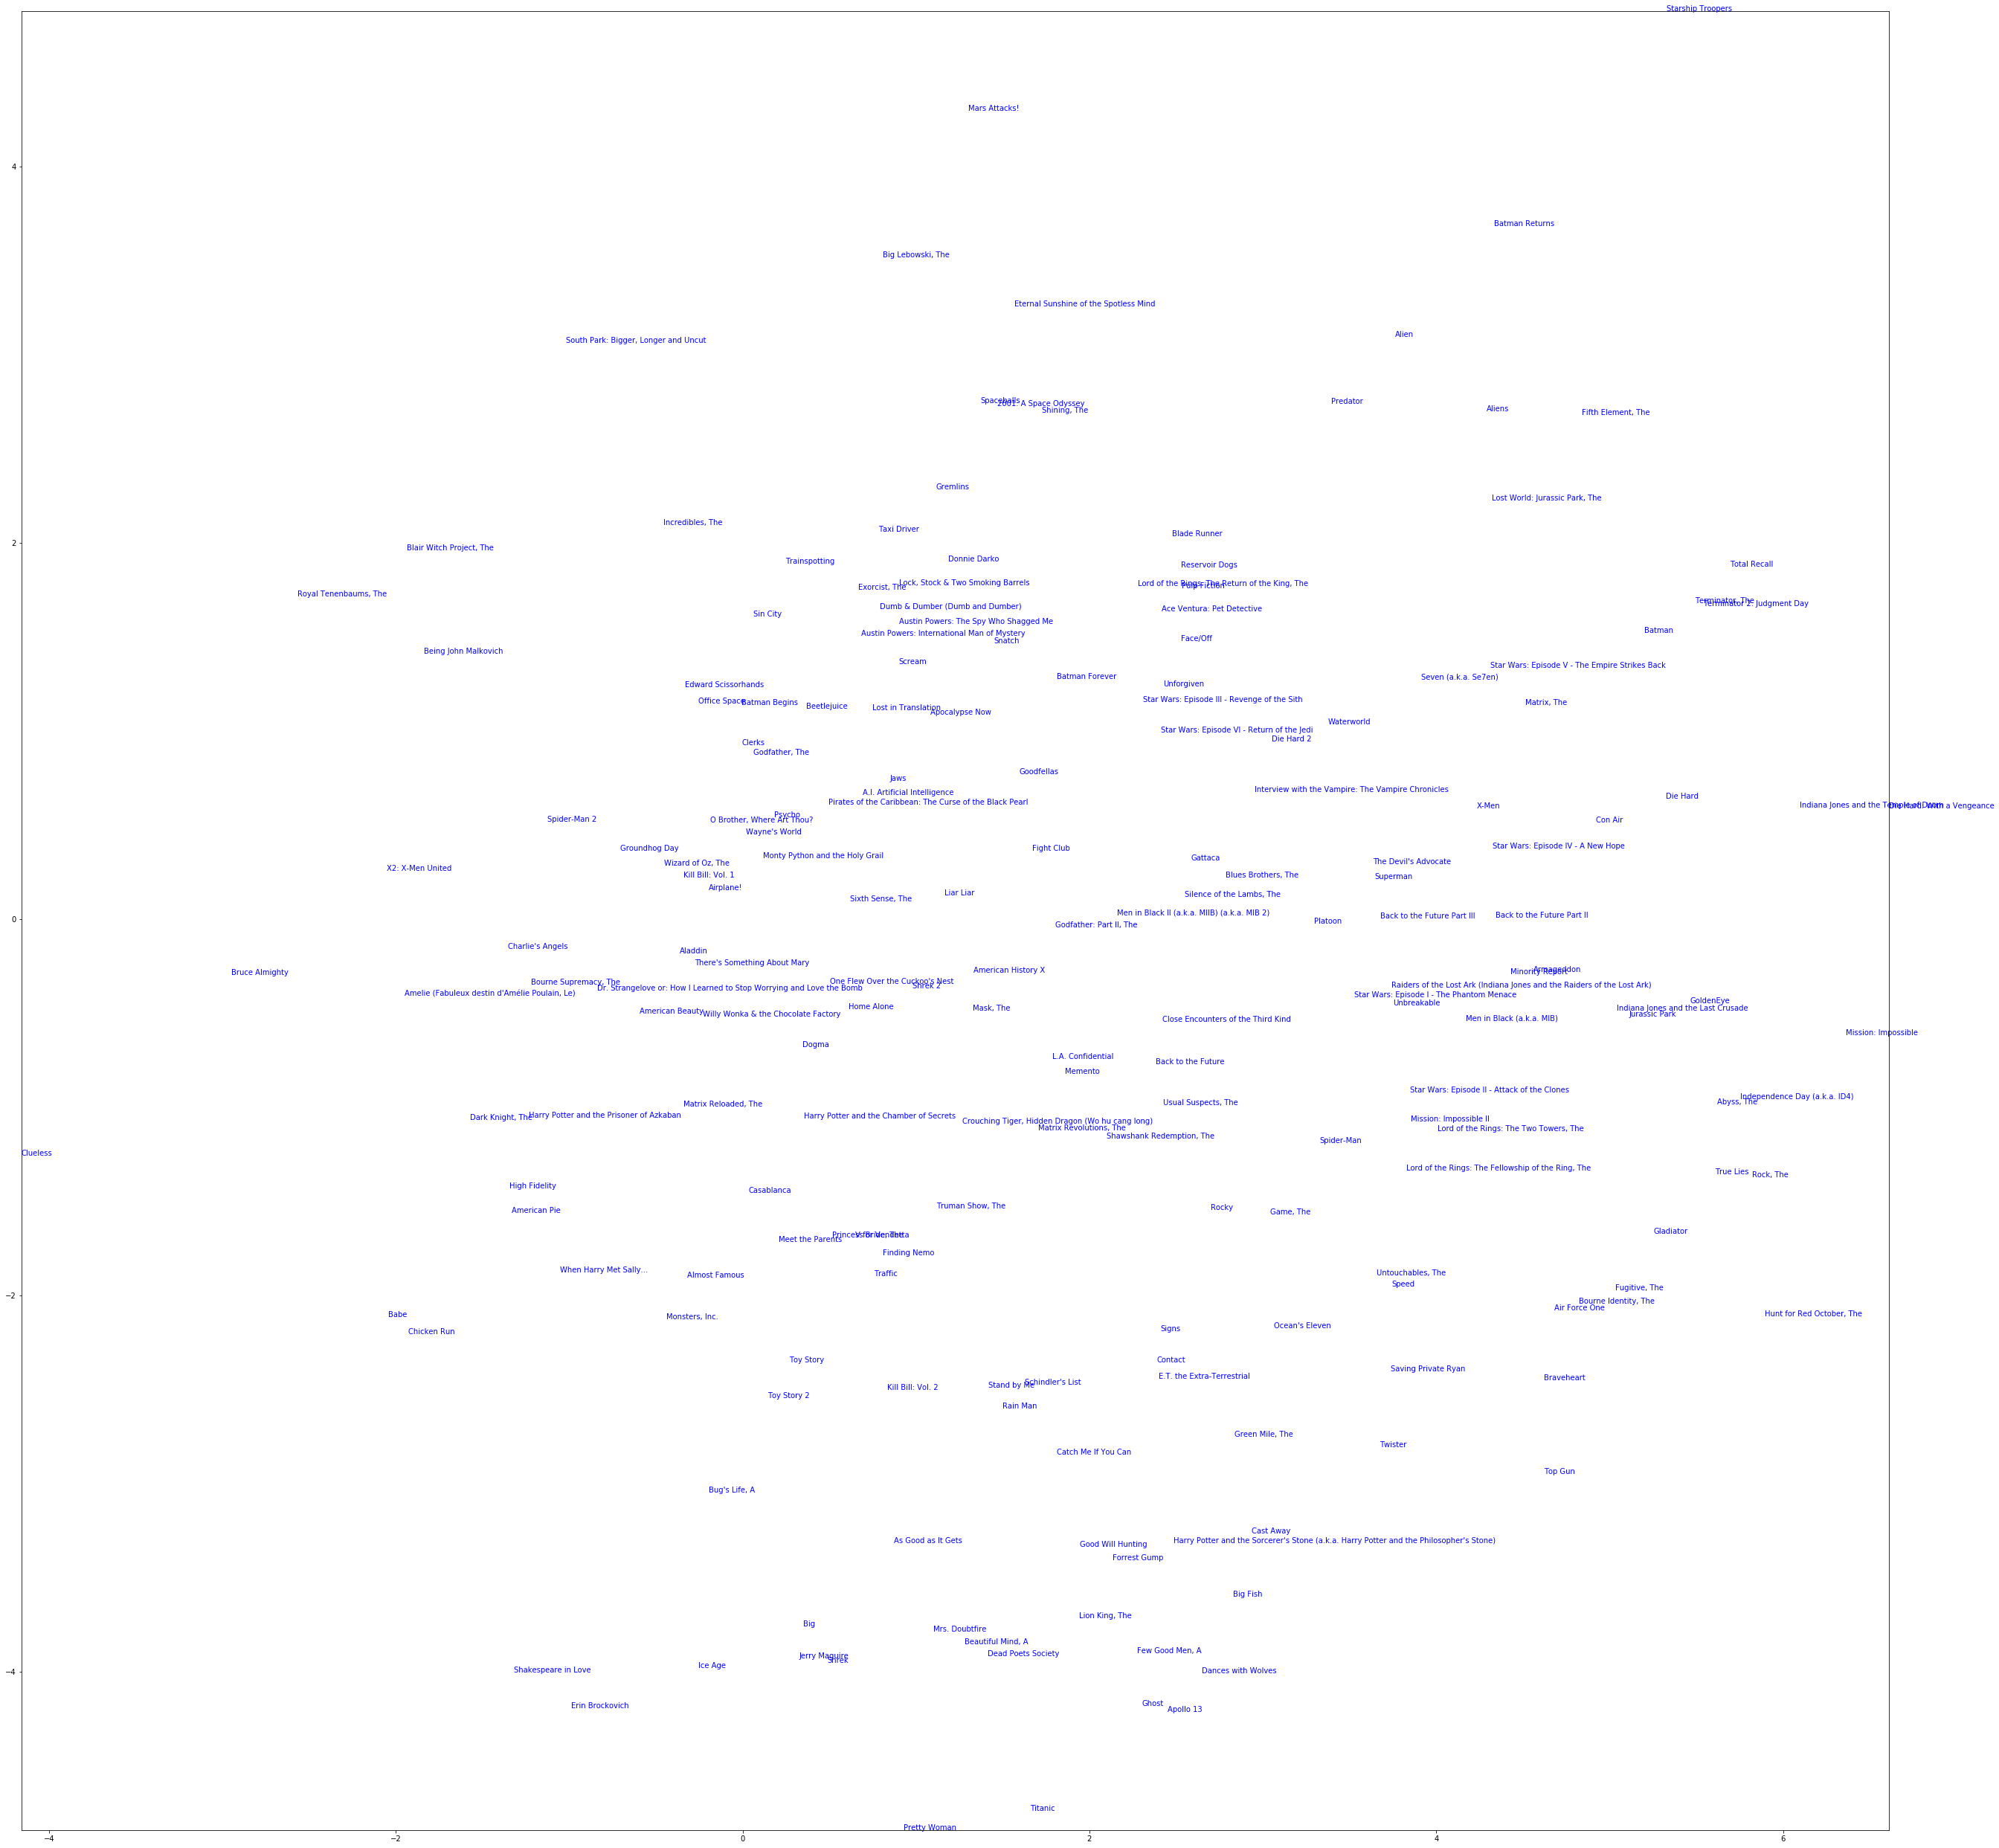

In [69]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
#Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [72]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Star Wars: Episode V - The Empire Strikes Back
   Star Wars: Episode IV - A New Hope
   Terminator 2: Judgment Day
   Captain America: Civil War
   Terminator, The
   Tron: Legacy
   RoboCop
   Bourne Legacy, The
   Aliens
   X-Men
   X-Men: Apocalypse

Movie:Forrest Gump
   As Good as It Gets
   Dead Poets Society
   Beautiful Mind, A
   Jerry Maguire
   Good Will Hunting
   Green Mile, The
   Finding Forrester
   Truman Show, The
   Sisterhood of the Traveling Pants, The
   Inherent Vice
   Philadelphia

Movie:Back to the Future
   Back to the Future Part II
   E.T. the Extra-Terrestrial
   Toy Story
   Jurassic Park
   Princess Bride, The
   Signal, The
   Young Frankenstein
   Terminator 2: Judgment Day
   Toy Story 2
   RoboCop
   Star Wars: Episode IV - A New Hope

Movie:Pulp Fiction
   Reservoir Dogs
   Silence of the Lambs, The
   Goodfellas
   Usual Suspects, The
   Seven (a.k.a. Se7en)
   Big Lebowski, The
   Taxi Driver
   L.A. Confidential
   Godfather:

In [0]:
movie_embedding = CF.movie_embedding.weight.data.detach().cpu().numpy()
user_embedding = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
genres_weight = CF.genres_layers[0].weight.data.detach().cpu().numpy()
genres_bias = CF.genres_layers[0].bias.data.detach().cpu().numpy()

In [0]:
model_weights = {'genres_weight':genres_weight,
                'genres_bias':genres_bias,
                }

In [0]:
model_weights['genres_list'] = genres_list
model_weights['genres_dict'] = genres_dict


In [0]:
kw_embedding_np = dict((k,v.detach().cpu().numpy()[0][0]) for (k,v) in kw_embedding.items())

In [0]:
model_weights['kw_embedding'] = kw_embedding_np
model_weights['kw_default_embedding'] = kw_default_embedding.detach().cpu().numpy()[0][0]
model_weights['kw_set'] = kw_set

In [0]:
def get_query_vector(query, model_weights):
    kws = [kw.lower() for kw in query.split(' ')]
    n = 0
    res = np.zeros(64)
    for kw in kws:
        if kw in model_weights['kw_set']:
            print(kw)
            res+=model_weights['kw_embedding'][kw]
            n+=1
    if n==0:
        return model_weights['kw_default_embedding']
    else:
        return res/n

In [0]:
def get_genre_vector(genres, model_weights):
    v = np.zeros((22,1))
    for g in genres:
        if g in model_weights['genres_dict']:
            v[model_weights['genres_dict'][g]]=1
    
    return model_weights['genres_weight'].dot(v).squeeze(1)+model_weights['genres_bias']

In [0]:
def compute_final_embedding(model_weights, query, user_embedding, genres):
    query_embedding = get_query_vector(query, model_weights)
    genres_embedding = get_genre_vector(genres, model_weights)
    
    x = 0.3*user_embedding + 0.2*genres_embedding + 0.5*query_embedding
    
    return x[0]

In [0]:
querys = 'toy story buzz lightyear tom hanks disney'
genres_q = ['animation','family']

In [96]:
a = compute_final_embedding(model_weights, querys, ave_User_Em, genres_q)

toy
story
buzz
tom
hanks
disney


In [97]:
score = Movie_Em.dot(a.T)
movie_id = np.argsort(score)[::-1][:50]
movie_df.iloc[list(movie_id)]

,index,Unnamed: 0,title,movieId,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating
1331,1331,1331,"Monsters, Inc.",3916,1331,585,2001,"comedy,family,animation",than fun tale inc monster more once 3 d silver...,3358,3.767719,0.850418
2099,2099,2099,Deuce Bigalow: European Gigolo,6945,2100,11453,2005,comedy,painter wig rob europe golden pimp bigelow ams...,394,1.885787,1.084074
2353,2353,2353,Unaccompanied Minors,7421,2354,18147,2006,"comedy,family",tree lewis black paul holiday eve kids valderr...,63,2.396825,0.967866
1655,1655,1655,Dumb and Dumberer: When Harry Met Lloyd,4983,1656,10152,2003,comedy,dumb lloyd met olsen and when luis to see chri...,639,1.576682,1.020359
2963,2963,2963,Shrek Forever After (a.k.a. Shrek: The Final C...,8638,2964,10192,2010,"comedy,family,adventure,animation,fantasy",animation mitchell diaz robinson imax myers ru...,669,2.824365,1.017521
2564,2564,2564,"Hammer, The",7860,2565,14014,2007,comedy,independent carolla california olympics r heat...,84,3.505952,0.704948
217,217,217,Singin' in the Rain,703,217,872,1952,"comedy,music,romance",100 kelley happy and girl snobbish tap debbie ...,1821,3.953322,0.989237
2973,2973,2973,Grown Ups,8655,2974,38365,2010,comedy,maria sandler scenes unfunny dennis salma foot...,570,2.513158,1.065229
2702,2702,2702,Yes Man,8121,2703,10201,2008,comedy,scenes jim reed zooey persians motivation man ...,1202,3.110233,0.878385
2653,2653,2653,Miracle at St. Anna,8033,2654,12412,2008,"war,drama",spike ealy toscana world village derek bob ola...,94,2.962766,0.836786
